In [1]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from notebooks.mnist_classifier.mnist_tiny_cnn import TinyCNN

from mixer.mixer import SetMixer
from datasets.mnist import MNISTDataset

from torch.utils.data import DataLoader
from itertools import product

from sklearn.decomposition import PCA

from tqdm.notebook import tqdm


In [2]:
device = 'cuda'
configs = get_all_experiments_info('outputs/', False)
cfg = [c for c in configs if 'mnist_multinomial' in c['name'] 
                    and c['encoder']=='ConvDistributionEncoder']
cfg = cfg[0]

In [ ]:
# load model and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

In [4]:
N = 1200  # must be divisible by 3
blk = N // 3

# build base row pattern
row = torch.cat([torch.zeros(blk), torch.ones(blk), torch.zeros(blk)])
mix_probs = torch.stack([row]*N)

In [5]:
dataset = MNISTDataset(n_classes=3, n_sets=N, set_size=5000)
encoder, generator = load_model(cfg['config'], cfg['dir'], 'cuda')

In [6]:
loss_records = []
all_z = []
all_ss = []

with torch.no_grad():
    for ss in tqdm(np.logspace(1, 4, 4, dtype=int)):
        mixer = SetMixer(k=3, mixed_set_size=ss, n_mixed_sets=N)
        mixed_sets = mixer.prescribed_mixing(dataset.data.flatten(start_dim=2), mix_probs)
        mixed_sets = mixed_sets.to(torch.float).reshape(-1, ss, 1, 28, 28)
        dataset.data = mixed_sets
        loader = DataLoader(dataset, batch_size=1, shuffle=False)

        for batch in loader:
            x = batch['samples'].to('cuda')
            z = encoder(x)

            loss = generator.loss(x.view(-1, *x.shape[2:]), z)

            loss_records.append({'loss': loss.item(), 'ss': ss})
            all_z.append(z.squeeze().cpu())
            all_ss.append(ss)

# combine z + ss
z_all = torch.stack(all_z).numpy()
ss_all = np.array(all_ss)

# pca fit on all z
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_all)

# dataframe for plotting
vis_df = pd.DataFrame({'PC1': z_pca[:, 0], 'PC2': z_pca[:, 1], 'ss': ss_all})
loss_df = pd.DataFrame(loss_records)


  0%|          | 0/4 [00:00<?, ?it/s]

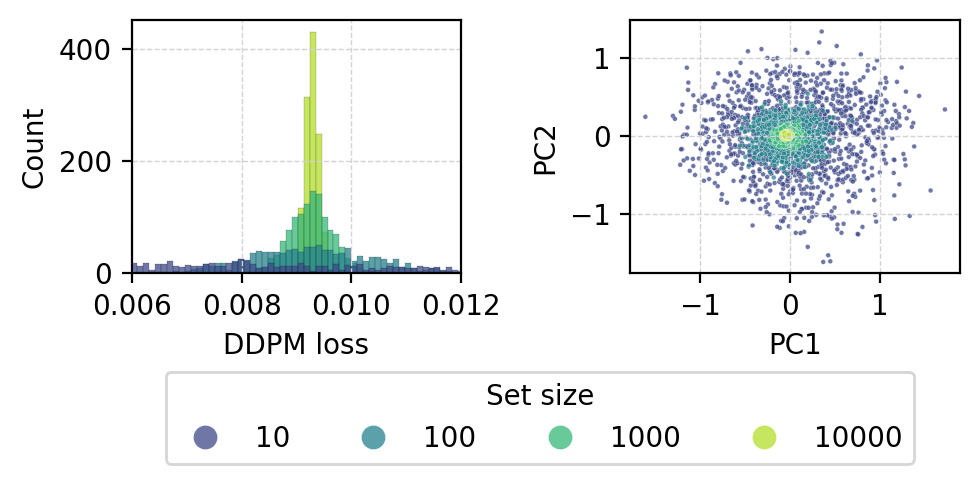

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2), dpi=200, gridspec_kw={'width_ratios': [1, 1]})

# Plot the histogram on the first axis
sns.histplot(
    data=loss_df,
    x='DDPM loss',
    hue='Set size',
    palette=sns.color_palette('viridis', 8)[1::2],
    fill=True,
    bins=200,
    alpha=0.75,
    ax=axes[0]
)
axes[0].set_xlim(0.006, 0.012)
axes[0].grid(True, color='lightgrey', linestyle='--', linewidth=0.5, zorder=0)

# Plot the scatter plot on the second axis
scatter = sns.scatterplot(
    data=vis_df,
    x='PC1',
    y='PC2',
    hue='ss',
    palette=sns.color_palette('viridis', 8)[1::2],
    s=3,
    alpha=0.75,
    ax=axes[1]
)
axes[1].grid(True, color='lightgrey', linestyle='--', linewidth=0.5, zorder=0)

# Combine the legend for both plots
handles, labels = scatter.get_legend_handles_labels()
fig.legend(
    handles, labels, loc='upper center', ncol=4, title="Set size", bbox_to_anchor=(0.55, 0.08),
        markerscale=5)

# Remove individual legends
axes[0].get_legend().remove()
axes[1].get_legend().remove()

plt.tight_layout()
plt.show()

In [39]:
loss_df.to_csv('numerical_results/clt_loss.csv')
vis_df.to_csv('numerical_results/clt_vis.csv')